#### Teoria
https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#stochastic-policies

In [1]:
import numpy as np
import torch

### Sum en axis

In [7]:
m1 = np.array([[1,1],
              [2,2]])
m1.sum(axis=-1)

array([2, 4])

In [14]:
m2 = np.array([[[1,1],
                [2,2]],
              [[3,3],
                [4,4]]])

In [15]:
m2.sum(axis=0)

array([[4, 4],
       [6, 6]])

In [16]:
m2.sum(axis=1)

array([[3, 3],
       [7, 7]])

In [20]:
print(m2.shape)
m2.sum(axis=-1).shape
m2.sum(axis=-1)

(2, 2, 2)


array([[2, 4],
       [6, 8]])

### Gaussian loglike w tensors

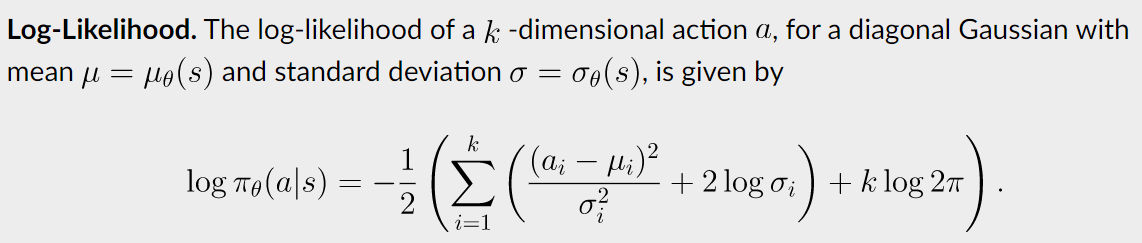

In [227]:
#Simular batch size de n con m acciones
n = 10
m = 4

mu = torch.rand(n,m)
log_std = torch.randn(n,m)
x = torch.rand(n,m) + torch.randn(n,m)

In [228]:
#Se tiene el NGLL para cada batch para cada accion, colapsar con un sum(axis-1) para hacer backward
-1/2 * ((x-mu)/torch.exp(log_std))**2 + 2*log_std + torch.log(torch.tensor(2*np.pi))

tensor([[-2.1290e+00, -3.3552e+00,  3.8945e+00, -7.1340e+00],
        [ 1.7905e+00, -5.1715e-01,  1.8557e+00, -6.9678e-01],
        [-2.9767e-02,  3.9568e+00, -1.0428e+01,  3.8577e+00],
        [ 6.1793e-02,  5.5111e-01,  7.3174e-01,  1.8294e+00],
        [ 2.6577e+00, -1.5057e+01,  1.2696e+00,  3.1421e+00],
        [-1.8822e+01,  4.3476e+00,  5.4343e+00, -1.8187e+01],
        [ 3.0319e+00,  5.2878e+00,  2.1867e+00,  1.8062e+00],
        [ 2.1902e+00,  3.2381e+00, -4.0039e+00,  2.5315e-01],
        [ 2.2749e+00,  6.5806e+00, -1.4466e+02,  2.0766e+00],
        [ 2.4418e+00, -3.1045e+01,  1.6870e+00,  1.6346e+00]])

In [229]:
def gaussianLogLikelihood(x, mu, log_std):
    pre_sum = -1/2 * ((x-mu)/torch.exp(log_std))**2 + 2*log_std + torch.log(torch.tensor(2*np.pi))
    return pre_sum.sum(axis=-1)

In [230]:
gaussianLogLikelihood(x,mu,log_std)

tensor([  -8.7237,    2.4323,   -2.6430,    3.1740,   -7.9879,  -27.2273,
          12.3126,    1.6775, -133.7290,  -25.2812])

### Simulacion de training

In [249]:
n = 10
m = 4

In [290]:
input_tensor = torch.randint(0,2,(n,11))

w1 = torch.rand((11,125), requires_grad = True)
b1 = torch.rand((n,125), requires_grad = True)
w2 = torch.rand(125,m, requires_grad = True) #4 acciones
smax = torch.nn.Softmax(dim=-1)

In [291]:
#Forward MU
logits = smax((input_tensor.float()@w1 + b1) @ w2)

In [295]:
log_std = torch.randn(m) #
x = torch.rand(n,m) + torch.randn(n,m) #past actions

In [296]:
#con log std dev
loss = gaussianLogLikelihood(x, logits, log_std)

In [327]:
loss

tensor([  -1.7128, -274.7336,  -25.0624,   -3.6214, -145.8330, -102.9627,
         -85.5346, -127.8138, -437.9500,  -13.3083], grad_fn=<SumBackward1>)

In [326]:
#Con log variance
torch.nn.GaussianNLLLoss(reduction='none')(x,logits,torch.exp(torch.randn(n,m))).sum(axis=-1)

tensor([ 2.0053,  6.0426,  9.8564, -0.8502,  2.9212,  2.9794,  1.4590,  5.7360,
         3.5571,  6.7674], grad_fn=<SumBackward1>)

In [298]:
#Multiplicar por rewards normalizados
loss.mean().backward()

In [299]:
w1.grad

tensor([[-3.3452e-03,  5.5080e-03, -4.2654e-04,  ..., -8.4920e-05,
          8.0119e-04,  3.7310e-03],
        [ 3.4986e-02, -5.7654e-02,  4.4364e-03,  ...,  8.8240e-04,
         -8.4136e-03, -3.9070e-02],
        [ 3.9001e-04, -6.4216e-04,  4.9728e-05,  ...,  9.9009e-06,
         -9.3410e-05, -4.3499e-04],
        ...,
        [-5.9208e-01,  9.7483e-01, -7.5449e-02,  ..., -1.4999e-02,
          1.4179e-01,  6.6033e-01],
        [ 3.7294e-02, -6.1455e-02,  4.7307e-03,  ...,  9.4100e-04,
         -8.9666e-03, -4.1645e-02],
        [-5.7723e-01,  9.5042e-01, -7.3526e-02,  ..., -1.4613e-02,
          1.3826e-01,  6.4382e-01]])

In [300]:
optim = torch.optim.Adam([w1,b1,w2], lr=1e-3)

In [301]:
w1

tensor([[0.3443, 0.2681, 0.3651,  ..., 0.4543, 0.2719, 0.8729],
        [0.3302, 0.8931, 0.9218,  ..., 0.4576, 0.7039, 0.1109],
        [0.5931, 0.4774, 0.9212,  ..., 0.9860, 0.0795, 0.6002],
        ...,
        [0.4560, 0.7235, 0.9040,  ..., 0.0526, 0.5069, 0.5439],
        [0.0130, 0.3937, 0.5047,  ..., 0.6223, 0.5205, 0.1431],
        [0.6090, 0.1612, 0.2528,  ..., 0.4582, 0.2885, 0.5310]],
       requires_grad=True)

In [302]:
optim.step()

In [303]:
w1

tensor([[0.3453, 0.2671, 0.3661,  ..., 0.4553, 0.2709, 0.8719],
        [0.3292, 0.8941, 0.9208,  ..., 0.4566, 0.7049, 0.1119],
        [0.5921, 0.4784, 0.9202,  ..., 0.9850, 0.0805, 0.6012],
        ...,
        [0.4570, 0.7225, 0.9050,  ..., 0.0536, 0.5059, 0.5429],
        [0.0120, 0.3947, 0.5037,  ..., 0.6213, 0.5215, 0.1441],
        [0.6100, 0.1602, 0.2538,  ..., 0.4592, 0.2875, 0.5300]],
       requires_grad=True)

### Ejemplo de sampling de accion

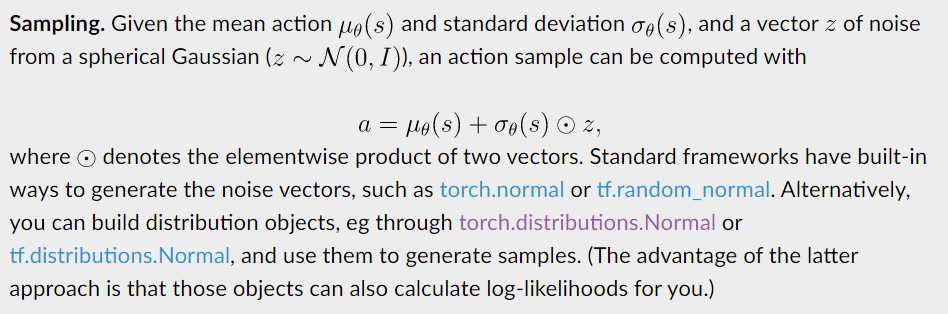

In [267]:
logits

tensor([[289.8850, 280.2348, 266.1241, 281.3204],
        [231.5907, 217.7921, 211.3837, 226.7488],
        [159.4197, 151.9398, 149.5630, 158.2559],
        [ 62.2171,  57.5156,  56.3980,  57.1622],
        [263.0890, 250.6349, 242.4621, 259.4616],
        [238.3841, 226.3925, 215.1390, 229.8743],
        [163.5909, 160.4815, 152.7206, 162.9150],
        [229.7657, 220.6039, 211.8378, 227.5165],
        [232.1260, 222.7709, 214.6545, 227.8951],
        [261.5237, 247.5105, 234.9483, 253.3621]], grad_fn=<MmBackward>)

In [276]:
log_std

tensor([ 0.0119, -1.5685,  2.0167, -0.6493])

In [308]:
mus = torch.nn.Softmax(-1)(logits)

In [317]:
actions = mus + torch.exp(log_std)*torch.randn(m)

In [318]:
actions

tensor([[ 2.0817,  0.2295,  0.2944, -0.0555],
        [ 2.0669,  0.2318,  0.3046, -0.0533],
        [ 2.0818,  0.2295,  0.2943, -0.0555],
        [ 2.0822,  0.2295,  0.2940, -0.0556],
        [ 2.0822,  0.2295,  0.2940, -0.0556],
        [ 2.0822,  0.2295,  0.2940, -0.0556],
        [ 2.0794,  0.2299,  0.2959, -0.0552],
        [ 2.0805,  0.2297,  0.2952, -0.0553],
        [ 2.0823,  0.2295,  0.2940, -0.0556],
        [ 2.0705,  0.2313,  0.3021, -0.0538]], grad_fn=<AddBackward0>)

### Multilayered Perceptron

In [431]:
n = 10
m = 4
input_tensor = torch.randint(0,2,(n,11)).float()
log_var = torch.nn.Parameter(torch.randn((n,m)))

In [468]:
model = torch.nn.Sequential(
        torch.nn.Linear(11,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,4),
        #torch.nn.Softmax(dim=-1)
        )

In [474]:
optim = torch.optim.Adam(model.parameters())

In [475]:
#EMPTY GRADIENT
optim.zero_grad()
#Actions
mu_out = model(input_tensor)

In [435]:
actions = mu_out + log_var*torch.randn((n,m))

In [436]:
#Segunda corrida para generar nuevas medias
input2_tensor = torch.randint(0,2,(n,11)).float()
mu_2 = model(input2_tensor)

In [437]:
loss = torch.nn.GaussianNLLLoss()
loss = loss(actions,mu_2,torch.exp(log_var))

In [438]:
loss.backward()

In [439]:
optim.step()

In [476]:
actions

tensor([[-0.7370,  0.4719,  0.2317,  1.1797],
        [-0.8898,  0.1227,  0.3988,  0.2558],
        [ 0.2047, -0.4067,  0.8150,  0.1397],
        [-0.4337, -0.9692,  0.7049,  0.9009],
        [-0.8817,  0.4896,  1.0800,  1.6902],
        [-1.1495, -0.2007,  0.1635, -1.0477],
        [-0.0309,  0.5593,  0.1936, -0.4758],
        [-0.0706,  1.2384,  1.0189,  0.2684],
        [ 0.6997, -0.2701,  0.6305,  0.1490],
        [ 0.2909, -1.0987,  0.1955,  0.3902]], grad_fn=<AddBackward0>)

In [556]:
log_var = torch.rand((1,4))-0.5

In [557]:
#Seleccionando una accion
with torch.no_grad():
    mu = model(torch.randint(0,2,(1,11)).float())
    action = mu + torch.sqrt(torch.exp(log_var))*torch.randn((1,4))
    print(action)

tensor([[ 0.1068, -0.4748, -1.4529,  0.9031]])
